In [34]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score # Otra métrica para evaluar clusters
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency # Para prueba Chi-cuadrado

# Clusterización usando K-Means
De acuerdo a la conclusión anterior, realizaremos un análisis con el módelo k-means, el cual nos traerá por medio de aprendizaje no-supervisado grupos de CVs con varios factores en común, desde los cuales podremos obtener una conclusión inicial para el objetivo de nuestro proyecto.

Datos cargados desde '../Bases/base_cvs/datos_para_clusterisar.csv'. Dimensiones: (614, 50)
Columnas disponibles: ['Numero de Paginas', 'Densidad Informacion (%)', 'Fechas Detectadas (Count)', 'Tamaño cuerpo probable', 'Variedad de fuentes', 'Variedad de tamaños', 'Uso de negritas (estimado %)', 'Uso de cursivas (estimado %)', 'Porcentaje Lenguaje Técnico', 'LinkedIn', 'GitHub', 'Website/Otro', 'Cantidad de imágenes', 'Tiene Elementos Graficos', 'Lineas_education', 'Lineas_work_experience', 'Lineas_skills', 'Lineas_certifications', 'Lineas_achievements', 'Lineas_professional_profile', 'Lineas_languages', 'Lineas_projects', 'Lineas_publications', 'Lineas_training_courses', 'Lineas_volunteer_work', 'Seccion_languages', 'Seccion_publications', 'Seccion_training_courses', 'texto_extraido_len', 'Promedio tamaño fuente', 'Formato Texto (Lineas)_Párrafos', 'Formato Texto (Lineas)_Viñetas', 'Orden Temporal_Orden Temporal Detectado', 'Formato Fecha Más Común_MM-YYYY', 'Formato Fecha Más Común_M

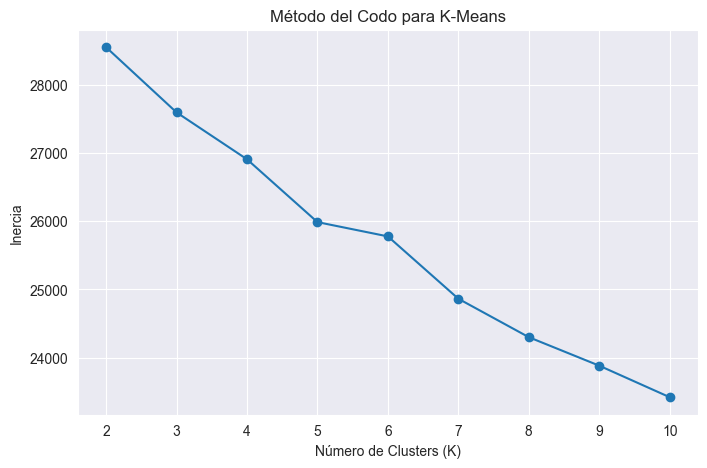

Observa el gráfico: elige el valor de K donde la línea 'forma un codo' (la disminución de la inercia se vuelve mucho más lenta).

>>> Aplicando K-Means con K=5 (¡Asegúrate de ajustar 'chosen_k' según el gráfico!) <<<

Etiquetas de cluster (0 a 4) añadidas al DataFrame (columna 'Cluster').

--- Análisis Descriptivo de los Clusters ---

Distribución de CVs por cluster:
Cluster
0     97
1    151
2    124
3    241
4      1
Name: count, dtype: int64

Medias de features por cluster:
Cluster                                                 0            1  \
Numero de Paginas                                1.948454     2.052980   
Densidad Informacion (%)                         6.892784     6.675695   
Fechas Detectadas (Count)                        1.164948     1.543046   
Tamaño cuerpo probable                           9.567010     9.536424   
Variedad de fuentes                              4.463918     5.291391   
Variedad de tamaños                              5.175258     7.523179   


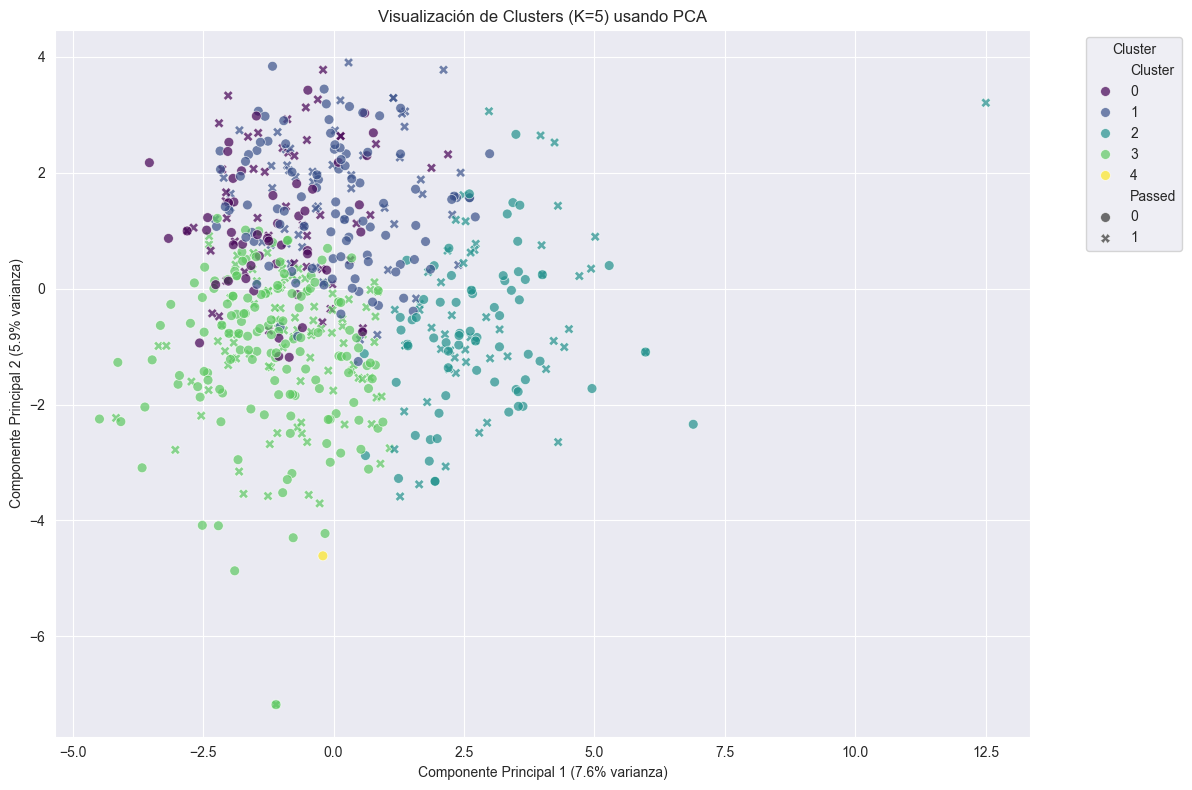

In [35]:
# --- 1. Cargar los Datos ---
# Asegúrate de que la ruta y el separador sean correctos para tu archivo
csv_path_cluster = '../Bases/base_cvs/datos_para_clusterisar.csv'
try:
    # Intentar detectar separador o especificarlo (ej. sep=',')
    df_cluster_orig = pd.read_csv(csv_path_cluster)
    print(f"Datos cargados desde '{csv_path_cluster}'. Dimensiones: {df_cluster_orig.shape}")
    print("Columnas disponibles:", df_cluster_orig.columns.tolist())
except FileNotFoundError:
    print(f"Error: No se encontró el archivo '{csv_path_cluster}'.")
    df_cluster_orig = None
except Exception as e:
    print(f"Error cargando datos: {e}")
    df_cluster_orig = None

# --- Solo proceder si los datos se cargaron ---
if df_cluster_orig is not None:

    # --- 2. Preparar Datos para Clustering ---
    target_column = 'Passed'

    # Verificar si 'Passed' existe y separarla (la usaremos después)
    if target_column in df_cluster_orig.columns:
        y_labels = df_cluster_orig[target_column].copy()
        X_cluster = df_cluster_orig.drop(columns=[target_column])
        print(f"\nSeparando features (X) y target '{target_column}'.")
    else:
        print(f"\nAdvertencia: Columna '{target_column}' no encontrada. Se usarán todas las columnas para clustering.")
        y_labels = None
        X_cluster = df_cluster_orig.copy()

    # Asegurar que todas las features son numéricas
    original_cols = X_cluster.shape[1]
    X_cluster = X_cluster.select_dtypes(include=np.number)
    if X_cluster.shape[1] < original_cols:
         print(f"Advertencia: Se eliminaron {original_cols - X_cluster.shape[1]} columnas no numéricas.")

    # Verificar y manejar NaNs (Imputar si es necesario)
    if X_cluster.isnull().sum().sum() > 0:
        print(f"\nAdvertencia: {X_cluster.isnull().sum().sum()} NaNs encontrados. Imputando con la media...")
        from sklearn.impute import SimpleImputer
        imputer_cluster = SimpleImputer(strategy='mean')
        X_cluster_imputed = imputer_cluster.fit_transform(X_cluster)
        X_cluster = pd.DataFrame(X_cluster_imputed, columns=X_cluster.columns)
        print("Imputación completada.")
    else:
        print("\nNo se encontraron NaNs en las features.")

    # Guardar nombres de features
    feature_names_cluster = X_cluster.columns.tolist()
    print(f"Número de features para clustering: {len(feature_names_cluster)}")

    # --- 3. Escalar TODAS las Features ---
    print("\nEscalando todas las features para K-Means...")
    scaler_cluster = StandardScaler()
    X_scaled_cluster = scaler_cluster.fit_transform(X_cluster)
    print("Escalado completado.")

    # --- 4. Determinar Número Óptimo de Clusters (K) - Método del Codo ---
    print("\nCalculando inercia para K de 2 a 10 (Método del Codo)...")
    inertia = []
    k_range = range(2, 11) # Puedes ajustar este rango si quieres probar más clusters

    for k in k_range:
        kmeans_test = KMeans(n_clusters=k, random_state=42, n_init=10) # n_init='auto' en sklearn >= 1.3
        kmeans_test.fit(X_scaled_cluster)
        inertia.append(kmeans_test.inertia_) # Inertia: Suma de cuadrados intra-cluster

    # Graficar el codo
    try:
        plt.figure(figsize=(8, 5))
        plt.plot(k_range, inertia, marker='o')
        plt.xlabel('Número de Clusters (K)')
        plt.ylabel('Inercia')
        plt.title('Método del Codo para K-Means')
        plt.xticks(k_range)
        plt.grid(True)
        plt.show()
        print("Observa el gráfico: elige el valor de K donde la línea 'forma un codo' (la disminución de la inercia se vuelve mucho más lenta).")
    except Exception as e_elbow_plot:
         print(f"No se pudo generar el gráfico del codo: {e_elbow_plot}")

    # --- 5. Aplicar K-Means con K elegido ---
    # *** AJUSTA EL VALOR DE 'chosen_k' BASADO EN EL GRÁFICO DEL CODO ***
    chosen_k = 5  # Ejemplo: Elegir 4 clusters. ¡CAMBIA ESTO!
    print(f"\n>>> Aplicando K-Means con K={chosen_k} (¡Asegúrate de ajustar 'chosen_k' según el gráfico!) <<<")

    kmeans_final = KMeans(n_clusters=chosen_k, random_state=42, n_init=10)
    cluster_labels = kmeans_final.fit_predict(X_scaled_cluster)

    # Añadir etiquetas de cluster al DataFrame ORIGINAL (el que tiene 'Passed' si existía)
    df_clustered = df_cluster_orig.copy() # Usar el original cargado
    df_clustered['Cluster'] = cluster_labels
    print(f"\nEtiquetas de cluster (0 a {chosen_k-1}) añadidas al DataFrame (columna 'Cluster').")

    # --- 6. Análisis Básico de los Clusters ---
    print("\n--- Análisis Descriptivo de los Clusters ---")

    # Tamaño de cada cluster
    print("\nDistribución de CVs por cluster:")
    print(df_clustered['Cluster'].value_counts().sort_index())

    # Características promedio por cluster (usando las features seleccionadas antes del escalado)
    print("\nMedias de features por cluster:")
    # Usar 'feature_names_cluster' para asegurar que agrupamos por las columnas correctas
    try:
        cluster_analysis = df_clustered.groupby('Cluster')[feature_names_cluster].mean().transpose()
        pd.set_option('display.max_rows', None) # Mostrar todas las features
        print(cluster_analysis)
        pd.reset_option('display.max_rows')
        print("\n(Interpreta esto buscando diferencias grandes en las medias entre clusters)")
    except Exception as e_group:
        print(f"Error al calcular medias por cluster: {e_group}")


    # Relación con 'Passed' (si la columna existe)
    if y_labels is not None:
        print("\n--- Relación Exploratoria entre Clusters y 'Passed' ---")
        # Tabla de contingencia
        contingency_table = pd.crosstab(df_clustered['Cluster'], y_labels)
        print("\nTabla de Contingencia (Cluster vs Passed):")
        print(contingency_table)

        # Porcentaje de 'Passed' en cada cluster
        passed_perc_by_cluster = df_clustered.groupby('Cluster')['Passed'].mean() * 100
        print("\nPorcentaje de 'Passed'=1 en cada cluster (%):")
        print(passed_perc_by_cluster.round(2))

        # Prueba Chi-cuadrado
        try:
            chi2, p, dof, expected = chi2_contingency(contingency_table)
            print(f"\nPrueba Chi-cuadrado (Cluster vs Passed): p-value = {p:.4f}")
            if p < 0.05:
                print("--> Asociación significativa encontrada: La proporción de 'Passed' varía entre clusters.")
            else:
                print("--> No hay asociación significativa: La proporción de 'Passed' es similar entre clusters.")
        except ValueError:
            print("\nAdvertencia: No se pudo realizar Chi-cuadrado (posiblemente datos insuficientes).")
    else:
         print("\nColumna 'Passed' no disponible para análisis cruzado con clusters.")


    # --- 7. (Opcional) Visualización PCA ---
    print("\nGenerando visualización 2D de clusters usando PCA...")
    try:
        pca = PCA(n_components=2, random_state=42)
        # Usamos los datos escalados para PCA también
        X_pca = pca.fit_transform(X_scaled_cluster)
        print(f"Varianza explicada por los 2 componentes PCA: {pca.explained_variance_ratio_.sum():.2%}")

        # Crear DataFrame para graficar
        df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
        df_pca['Cluster'] = cluster_labels
        if y_labels is not None: # Añadir 'Passed' si existe para colorear diferente
             df_pca['Passed'] = y_labels

        plt.figure(figsize=(12, 8))
        sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Cluster',
                        palette='viridis', s=50, alpha=0.7,
                        style='Passed' if y_labels is not None else None) # Diferente marcador si 'Passed' existe
        plt.title(f'Visualización de Clusters (K={chosen_k}) usando PCA')
        plt.xlabel(f'Componente Principal 1 ({pca.explained_variance_ratio_[0]:.1%} varianza)')
        plt.ylabel(f'Componente Principal 2 ({pca.explained_variance_ratio_[1]:.1%} varianza)')
        plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    except Exception as e_pca_plot:
        print(f"No se pudo generar gráfico PCA: {e_pca_plot}")


El primer proceso de clustering, con 49 variables, no nos trae resultados significativos, con una relación mínima frente a la pertenencia al cluster y la variable passed.

###  K-Means: Segunda base de datos

Clusterización solo con los datos con los que originalmente modelados y dijimos representaban el general de las CVS

Datos cargados desde '../Bases/base_cvs/datos_para_modelar_cv.csv'. Dimensiones: (614, 34)
Columnas disponibles: ['Passed', 'secciones_completas', 'texto_extraido_len', 'Porcentaje Lenguaje Técnico', 'Uso de negritas (estimado %)', 'Ratio_Lineas_Experiencia_len', 'Promedio tamaño fuente', 'Densidad Informacion (%)', 'Lineas_training_courses', 'Numero de Paginas', 'Variedad de tamaños', 'Variedad de fuentes', 'Uso de cursivas (estimado %)', 'Cantidad de imágenes', 'Fechas Detectadas (Count)', 'Website/Otro', 'Seccion_training_courses', 'Uso de colores (texto)_Sí', 'Orden Temporal_Orden Temporal Detectado', 'Legibilidad general_Buena', 'Consistencia tamaños fuente_Consistente', 'Consistencia márgenes (aprox)_Consistente', 'Deteccion Foto Perfil_Posible Foto Detectada', 'Formato Texto (Lineas)_Párrafos', 'Formato Texto (Lineas)_Viñetas', 'Fuente principal_Tahoma', 'Fuente principal_Otra', 'Formato Fecha Más Común_MM/YYYY', 'Formato Fecha Más Común_YYYY', 'Tiene Elementos Graficos', 'Linke

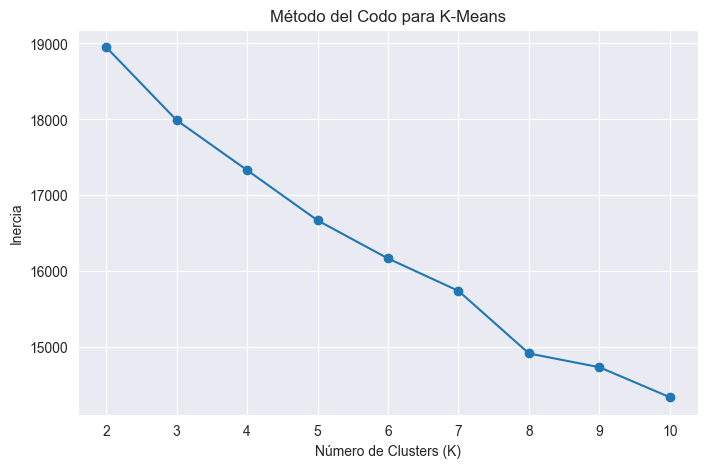

Observa el gráfico: elige el valor de K donde la línea 'forma un codo' (la disminución de la inercia se vuelve mucho más lenta).

>>> Aplicando K-Means con K=4 (¡Asegúrate de ajustar 'chosen_k' según el gráfico!) <<<

Etiquetas de cluster (0 a 3) añadidas al DataFrame (columna 'Cluster').

--- Análisis Descriptivo de los Clusters ---

Distribución de CVs por cluster:
Cluster
0    253
1     66
2    113
3    182
Name: count, dtype: int64

Medias de features por cluster:
Cluster                                                 0            1  \
secciones_completas                              7.754941     8.409091   
texto_extraido_len                            3912.399209  4232.212121   
Porcentaje Lenguaje Técnico                      8.024506     8.682424   
Uso de negritas (estimado %)                    20.267984    21.410606   
Ratio_Lineas_Experiencia_len                     0.003650     0.001908   
Promedio tamaño fuente                          13.804705    13.002938   
Densidad 

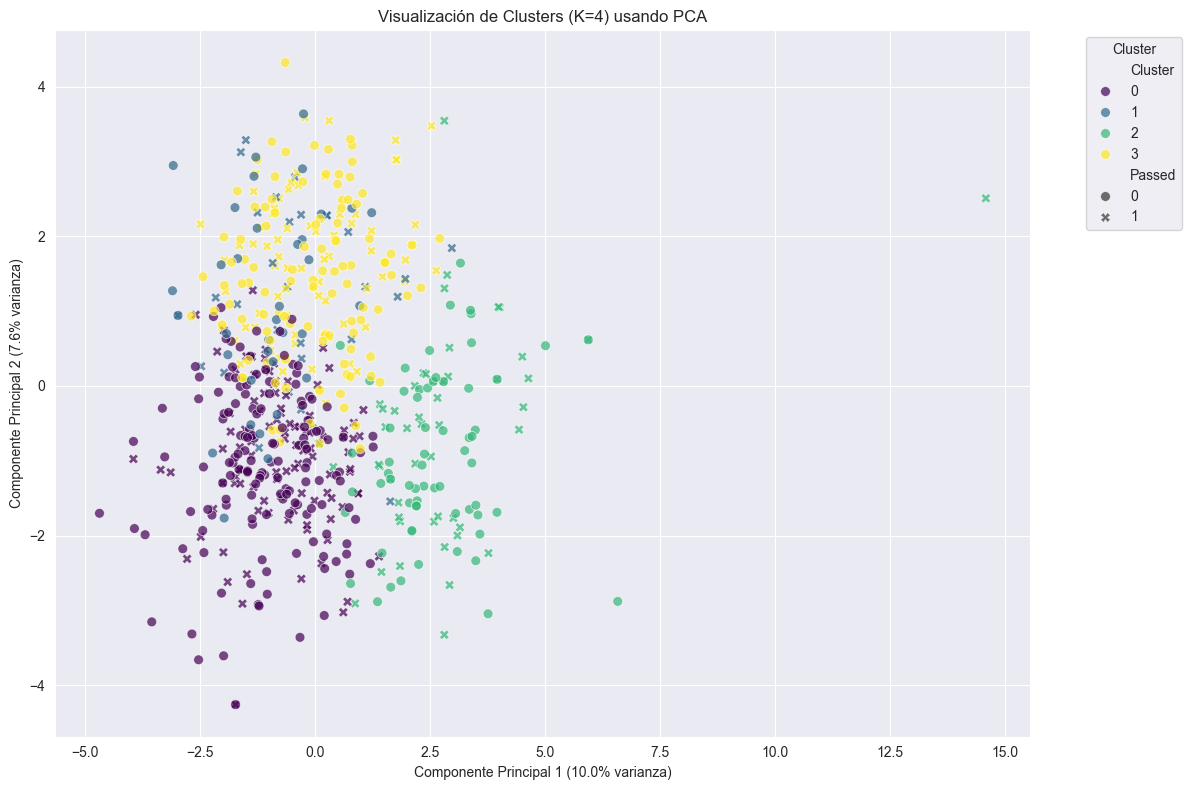

In [36]:
# --- 1. Cargar los Datos ---
# Asegúrate de que la ruta y el separador sean correctos para tu archivo
csv_path_cluster = '../Bases/base_cvs/datos_para_modelar_cv.csv'
try:
    # Intentar detectar separador o especificarlo (ej. sep=',')
    df_cluster_orig = pd.read_csv(csv_path_cluster)
    print(f"Datos cargados desde '{csv_path_cluster}'. Dimensiones: {df_cluster_orig.shape}")
    print("Columnas disponibles:", df_cluster_orig.columns.tolist())
except FileNotFoundError:
    print(f"Error: No se encontró el archivo '{csv_path_cluster}'.")
    df_cluster_orig = None
except Exception as e:
    print(f"Error cargando datos: {e}")
    df_cluster_orig = None

# --- Solo proceder si los datos se cargaron ---
if df_cluster_orig is not None:

    # --- 2. Preparar Datos para Clustering ---
    target_column = 'Passed'

    # Verificar si 'Passed' existe y separarla (la usaremos después)
    if target_column in df_cluster_orig.columns:
        y_labels = df_cluster_orig[target_column].copy()
        X_cluster = df_cluster_orig.drop(columns=[target_column])
        print(f"\nSeparando features (X) y target '{target_column}'.")
    else:
        print(f"\nAdvertencia: Columna '{target_column}' no encontrada. Se usarán todas las columnas para clustering.")
        y_labels = None
        X_cluster = df_cluster_orig.copy()

    # Asegurar que todas las features son numéricas
    original_cols = X_cluster.shape[1]
    X_cluster = X_cluster.select_dtypes(include=np.number)
    if X_cluster.shape[1] < original_cols:
         print(f"Advertencia: Se eliminaron {original_cols - X_cluster.shape[1]} columnas no numéricas.")

    # Verificar y manejar NaNs (Imputar si es necesario)
    if X_cluster.isnull().sum().sum() > 0:
        print(f"\nAdvertencia: {X_cluster.isnull().sum().sum()} NaNs encontrados. Imputando con la media...")
        from sklearn.impute import SimpleImputer
        imputer_cluster = SimpleImputer(strategy='mean')
        X_cluster_imputed = imputer_cluster.fit_transform(X_cluster)
        X_cluster = pd.DataFrame(X_cluster_imputed, columns=X_cluster.columns)
        print("Imputación completada.")
    else:
        print("\nNo se encontraron NaNs en las features.")

    # Guardar nombres de features
    feature_names_cluster = X_cluster.columns.tolist()
    print(f"Número de features para clustering: {len(feature_names_cluster)}")

    # --- 3. Escalar TODAS las Features ---
    print("\nEscalando todas las features para K-Means...")
    scaler_cluster = StandardScaler()
    X_scaled_cluster = scaler_cluster.fit_transform(X_cluster)
    print("Escalado completado.")

    # --- 4. Determinar Número Óptimo de Clusters (K) - Método del Codo ---
    print("\nCalculando inercia para K de 2 a 10 (Método del Codo)...")
    inertia = []
    k_range = range(2, 11) # Puedes ajustar este rango si quieres probar más clusters

    for k in k_range:
        kmeans_test = KMeans(n_clusters=k, random_state=42, n_init=10) # n_init='auto' en sklearn >= 1.3
        kmeans_test.fit(X_scaled_cluster)
        inertia.append(kmeans_test.inertia_) # Inertia: Suma de cuadrados intra-cluster

    # Graficar el codo
    try:
        plt.figure(figsize=(8, 5))
        plt.plot(k_range, inertia, marker='o')
        plt.xlabel('Número de Clusters (K)')
        plt.ylabel('Inercia')
        plt.title('Método del Codo para K-Means')
        plt.xticks(k_range)
        plt.grid(True)
        plt.show()
        print("Observa el gráfico: elige el valor de K donde la línea 'forma un codo' (la disminución de la inercia se vuelve mucho más lenta).")
    except Exception as e_elbow_plot:
         print(f"No se pudo generar el gráfico del codo: {e_elbow_plot}")

    # --- 5. Aplicar K-Means con K elegido ---
    # *** AJUSTA EL VALOR DE 'chosen_k' BASADO EN EL GRÁFICO DEL CODO ***
    chosen_k = 4  # Ejemplo: Elegir 4 clusters. ¡CAMBIA ESTO!
    print(f"\n>>> Aplicando K-Means con K={chosen_k} (¡Asegúrate de ajustar 'chosen_k' según el gráfico!) <<<")

    kmeans_final = KMeans(n_clusters=chosen_k, random_state=42, n_init=10)
    cluster_labels = kmeans_final.fit_predict(X_scaled_cluster)

    # Añadir etiquetas de cluster al DataFrame ORIGINAL (el que tiene 'Passed' si existía)
    df_clustered = df_cluster_orig.copy() # Usar el original cargado
    df_clustered['Cluster'] = cluster_labels
    print(f"\nEtiquetas de cluster (0 a {chosen_k-1}) añadidas al DataFrame (columna 'Cluster').")

    # --- 6. Análisis Básico de los Clusters ---
    print("\n--- Análisis Descriptivo de los Clusters ---")

    # Tamaño de cada cluster
    print("\nDistribución de CVs por cluster:")
    print(df_clustered['Cluster'].value_counts().sort_index())

    # Características promedio por cluster (usando las features seleccionadas antes del escalado)
    print("\nMedias de features por cluster:")
    # Usar 'feature_names_cluster' para asegurar que agrupamos por las columnas correctas
    try:
        cluster_analysis = df_clustered.groupby('Cluster')[feature_names_cluster].mean().transpose()
        pd.set_option('display.max_rows', None) # Mostrar todas las features
        print(cluster_analysis)
        pd.reset_option('display.max_rows')
        print("\n(Interpreta esto buscando diferencias grandes en las medias entre clusters)")
    except Exception as e_group:
        print(f"Error al calcular medias por cluster: {e_group}")


    # Relación con 'Passed' (si la columna existe)
    if y_labels is not None:
        print("\n--- Relación Exploratoria entre Clusters y 'Passed' ---")
        # Tabla de contingencia
        contingency_table = pd.crosstab(df_clustered['Cluster'], y_labels)
        print("\nTabla de Contingencia (Cluster vs Passed):")
        print(contingency_table)

        # Porcentaje de 'Passed' en cada cluster
        passed_perc_by_cluster = df_clustered.groupby('Cluster')['Passed'].mean() * 100
        print("\nPorcentaje de 'Passed'=1 en cada cluster (%):")
        print(passed_perc_by_cluster.round(2))

        # Prueba Chi-cuadrado
        try:
            chi2, p, dof, expected = chi2_contingency(contingency_table)
            print(f"\nPrueba Chi-cuadrado (Cluster vs Passed): p-value = {p:.4f}")
            if p < 0.05:
                print("--> Asociación significativa encontrada: La proporción de 'Passed' varía entre clusters.")
            else:
                print("--> No hay asociación significativa: La proporción de 'Passed' es similar entre clusters.")
        except ValueError:
            print("\nAdvertencia: No se pudo realizar Chi-cuadrado (posiblemente datos insuficientes).")
    else:
         print("\nColumna 'Passed' no disponible para análisis cruzado con clusters.")


    # --- 7. (Opcional) Visualización PCA ---
    print("\nGenerando visualización 2D de clusters usando PCA...")
    try:
        pca = PCA(n_components=2, random_state=42)
        # Usamos los datos escalados para PCA también
        X_pca = pca.fit_transform(X_scaled_cluster)
        print(f"Varianza explicada por los 2 componentes PCA: {pca.explained_variance_ratio_.sum():.2%}")

        # Crear DataFrame para graficar
        df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
        df_pca['Cluster'] = cluster_labels
        if y_labels is not None: # Añadir 'Passed' si existe para colorear diferente
             df_pca['Passed'] = y_labels

        plt.figure(figsize=(12, 8))
        sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Cluster',
                        palette='viridis', s=50, alpha=0.7,
                        style='Passed' if y_labels is not None else None) # Diferente marcador si 'Passed' existe
        plt.title(f'Visualización de Clusters (K={chosen_k}) usando PCA')
        plt.xlabel(f'Componente Principal 1 ({pca.explained_variance_ratio_[0]:.1%} varianza)')
        plt.ylabel(f'Componente Principal 2 ({pca.explained_variance_ratio_[1]:.1%} varianza)')
        plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    except Exception as e_pca_plot:
        print(f"No se pudo generar gráfico PCA: {e_pca_plot}")

De igual manera, el segundo modelamiento nos trae resultados no significativos frente a la posibilidad de pertenecer a un cluster y de pertenecer al grupo que pasó. Entendiendo que la gran mayoría de variables tenidas en cuenta, no son relevantes para pasar o no.

### K-Means
Variables con significancia estadística (9 y 4 variables)

#### 9 variables

In [37]:
selected_features9 = [
        'Porcentaje Lenguaje Técnico',
        'texto_extraido_len',
        'Uso de negritas (estimado %)',
        'Densidad Informacion (%)',
        'Numero de Paginas',
        'secciones_completas',
        'Website/Otro',               # Binaria (0/1)
        'Seccion_training_courses',   # Binaria (0/1) - El flag
        'Uso de colores (texto)_Sí',   # Binaria (0/1)
        'Passed'
    ]

df9 = df_cluster_orig[selected_features9]

In [38]:
df9

,Porcentaje Lenguaje Técnico,texto_extraido_len,Uso de negritas (estimado %),Densidad Informacion (%),Numero de Paginas,secciones_completas,Website/Otro,Seccion_training_courses,Uso de colores (texto)_Sí,Passed
0,3.72,3692,34.4,5.71,2,7,1,1,1,1
1,9.61,2703,0.0,8.09,1,8,1,1,0,1
2,8.58,2761,21.8,8.27,1,9,0,1,1,1
3,6.67,4732,16.2,3.54,4,7,0,1,0,1
4,11.29,4562,31.2,4.71,3,10,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...
609,6.72,8464,32.7,4.37,6,9,1,1,1,0
610,2.71,25210,8.1,7.54,10,8,0,1,0,0
611,5.04,6154,62.7,6.13,3,10,0,1,0,0
612,6.25,1313,0.0,3.93,1,8,0,1,0,0


Datos cargados desde '../Bases/base_cvs/datos_para_modelar_cv.csv'. Dimensiones: (614, 10)
Columnas disponibles: ['Porcentaje Lenguaje Técnico', 'texto_extraido_len', 'Uso de negritas (estimado %)', 'Densidad Informacion (%)', 'Numero de Paginas', 'secciones_completas', 'Website/Otro', 'Seccion_training_courses', 'Uso de colores (texto)_Sí', 'Passed']

Separando features (X) y target 'Passed'.

No se encontraron NaNs en las features.
Número de features para clustering: 9

Escalando todas las features para K-Means...
Escalado completado.

Calculando inercia para K de 2 a 10 (Método del Codo)...


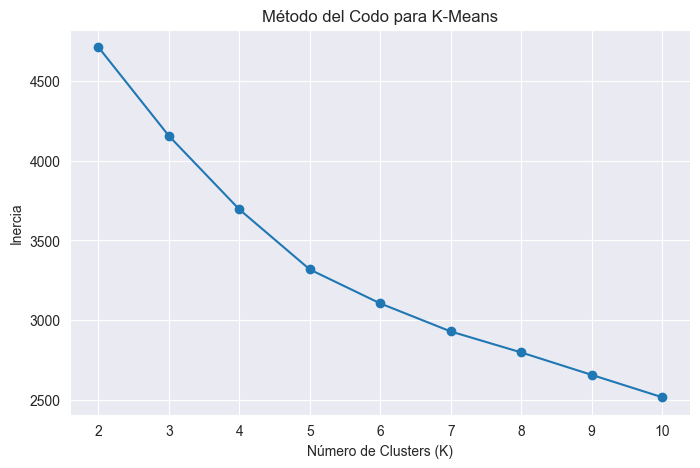

Observa el gráfico: elige el valor de K donde la línea 'forma un codo' (la disminución de la inercia se vuelve mucho más lenta).

>>> Aplicando K-Means con K=4 (¡Asegúrate de ajustar 'chosen_k' según el gráfico!) <<<

Etiquetas de cluster (0 a 3) añadidas al DataFrame (columna 'Cluster').

--- Análisis Descriptivo de los Clusters ---

Distribución de CVs por cluster:
Cluster
0    105
1    114
2    291
3    104
Name: count, dtype: int64

Medias de features por cluster:
Cluster                                 0            1            2  \
Porcentaje Lenguaje Técnico      8.116000     5.563070     7.843265   
texto_extraido_len            3191.047619  9135.473684  3752.020619   
Uso de negritas (estimado %)    19.234286    18.392982    21.421993   
Densidad Informacion (%)         6.009238     6.041316     5.844433   
Numero de Paginas                1.714286     5.342105     2.164948   
secciones_completas              6.895238     9.052632     8.216495   
Website/Otro                  

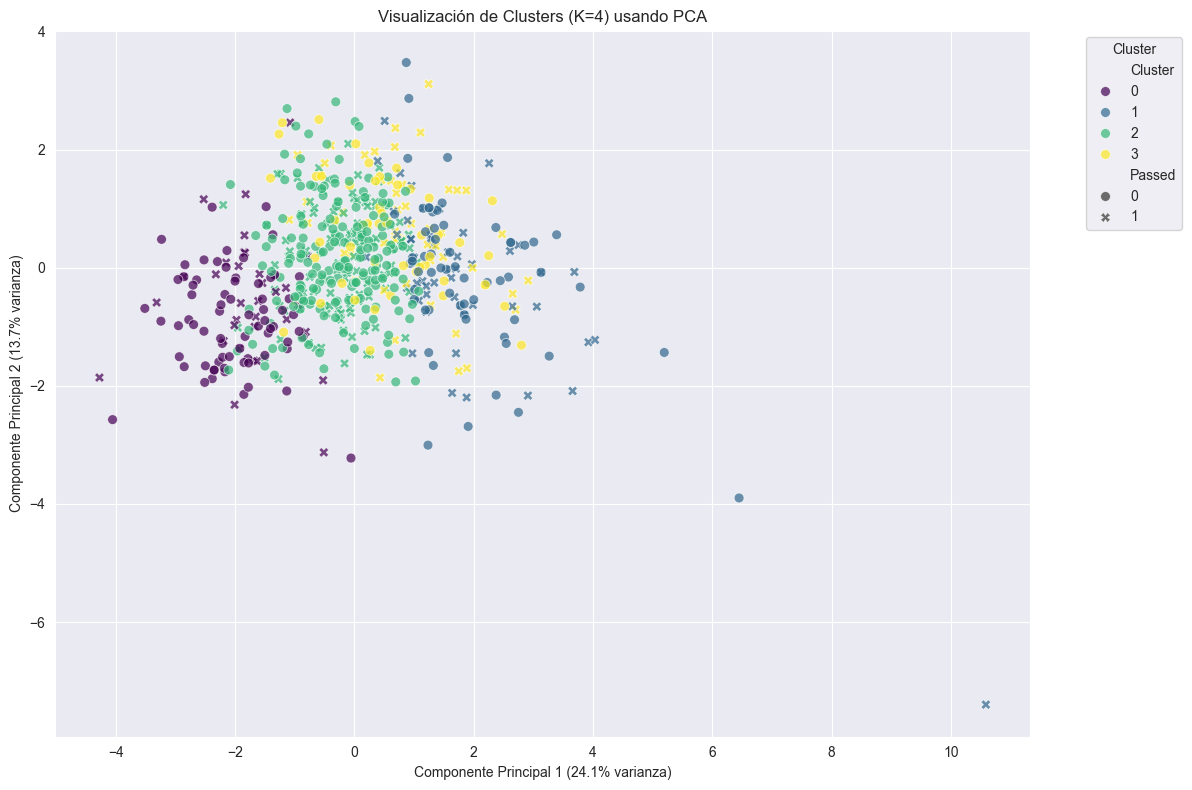

In [39]:
try:
    # Intentar detectar separador o especificarlo (ej. sep=',')
    df_cluster_orig = df9
    print(f"Datos cargados desde '{csv_path_cluster}'. Dimensiones: {df_cluster_orig.shape}")
    print("Columnas disponibles:", df_cluster_orig.columns.tolist())
except FileNotFoundError:
    print(f"Error: No se encontró el archivo '{csv_path_cluster}'.")
    df_cluster_orig = None
except Exception as e:
    print(f"Error cargando datos: {e}")
    df_cluster_orig = None

# --- Solo proceder si los datos se cargaron ---
if df_cluster_orig is not None:

    # --- 2. Preparar Datos para Clustering ---
    target_column = 'Passed'

    # Verificar si 'Passed' existe y separarla (la usaremos después)
    if target_column in df_cluster_orig.columns:
        y_labels = df_cluster_orig[target_column].copy()
        X_cluster = df_cluster_orig.drop(columns=[target_column])
        print(f"\nSeparando features (X) y target '{target_column}'.")
    else:
        print(f"\nAdvertencia: Columna '{target_column}' no encontrada. Se usarán todas las columnas para clustering.")
        y_labels = None
        X_cluster = df_cluster_orig.copy()

    # Asegurar que todas las features son numéricas
    original_cols = X_cluster.shape[1]
    X_cluster = X_cluster.select_dtypes(include=np.number)
    if X_cluster.shape[1] < original_cols:
         print(f"Advertencia: Se eliminaron {original_cols - X_cluster.shape[1]} columnas no numéricas.")

    # Verificar y manejar NaNs (Imputar si es necesario)
    if X_cluster.isnull().sum().sum() > 0:
        print(f"\nAdvertencia: {X_cluster.isnull().sum().sum()} NaNs encontrados. Imputando con la media...")
        from sklearn.impute import SimpleImputer
        imputer_cluster = SimpleImputer(strategy='mean')
        X_cluster_imputed = imputer_cluster.fit_transform(X_cluster)
        X_cluster = pd.DataFrame(X_cluster_imputed, columns=X_cluster.columns)
        print("Imputación completada.")
    else:
        print("\nNo se encontraron NaNs en las features.")

    # Guardar nombres de features
    feature_names_cluster = X_cluster.columns.tolist()
    print(f"Número de features para clustering: {len(feature_names_cluster)}")

    # --- 3. Escalar TODAS las Features ---
    print("\nEscalando todas las features para K-Means...")
    scaler_cluster = StandardScaler()
    X_scaled_cluster = scaler_cluster.fit_transform(X_cluster)
    print("Escalado completado.")

    # --- 4. Determinar Número Óptimo de Clusters (K) - Método del Codo ---
    print("\nCalculando inercia para K de 2 a 10 (Método del Codo)...")
    inertia = []
    k_range = range(2, 11) # Puedes ajustar este rango si quieres probar más clusters

    for k in k_range:
        kmeans_test = KMeans(n_clusters=k, random_state=42, n_init=10) # n_init='auto' en sklearn >= 1.3
        kmeans_test.fit(X_scaled_cluster)
        inertia.append(kmeans_test.inertia_) # Inertia: Suma de cuadrados intra-cluster

    # Graficar el codo
    try:
        plt.figure(figsize=(8, 5))
        plt.plot(k_range, inertia, marker='o')
        plt.xlabel('Número de Clusters (K)')
        plt.ylabel('Inercia')
        plt.title('Método del Codo para K-Means')
        plt.xticks(k_range)
        plt.grid(True)
        plt.show()
        print("Observa el gráfico: elige el valor de K donde la línea 'forma un codo' (la disminución de la inercia se vuelve mucho más lenta).")
    except Exception as e_elbow_plot:
         print(f"No se pudo generar el gráfico del codo: {e_elbow_plot}")

    # --- 5. Aplicar K-Means con K elegido ---
    # *** AJUSTA EL VALOR DE 'chosen_k' BASADO EN EL GRÁFICO DEL CODO ***
    chosen_k = 5  # Ejemplo: Elegir 4 clusters. ¡CAMBIA ESTO!
    print(f"\n>>> Aplicando K-Means con K={chosen_k} (¡Asegúrate de ajustar 'chosen_k' según el gráfico!) <<<")

    kmeans_final = KMeans(n_clusters=chosen_k, random_state=42, n_init=10)
    cluster_labels = kmeans_final.fit_predict(X_scaled_cluster)

    # Añadir etiquetas de cluster al DataFrame ORIGINAL (el que tiene 'Passed' si existía)
    df_clustered = df_cluster_orig.copy() # Usar el original cargado
    df_clustered['Cluster'] = cluster_labels
    print(f"\nEtiquetas de cluster (0 a {chosen_k-1}) añadidas al DataFrame (columna 'Cluster').")

    # --- 6. Análisis Básico de los Clusters ---
    print("\n--- Análisis Descriptivo de los Clusters ---")

    # Tamaño de cada cluster
    print("\nDistribución de CVs por cluster:")
    print(df_clustered['Cluster'].value_counts().sort_index())

    # Características promedio por cluster (usando las features seleccionadas antes del escalado)
    print("\nMedias de features por cluster:")
    # Usar 'feature_names_cluster' para asegurar que agrupamos por las columnas correctas
    try:
        cluster_analysis = df_clustered.groupby('Cluster')[feature_names_cluster].mean().transpose()
        pd.set_option('display.max_rows', None) # Mostrar todas las features
        print(cluster_analysis)
        pd.reset_option('display.max_rows')
        print("\n(Interpreta esto buscando diferencias grandes en las medias entre clusters)")
    except Exception as e_group:
        print(f"Error al calcular medias por cluster: {e_group}")


    # Relación con 'Passed' (si la columna existe)
    if y_labels is not None:
        print("\n--- Relación Exploratoria entre Clusters y 'Passed' ---")
        # Tabla de contingencia
        contingency_table = pd.crosstab(df_clustered['Cluster'], y_labels)
        print("\nTabla de Contingencia (Cluster vs Passed):")
        print(contingency_table)

        # Porcentaje de 'Passed' en cada cluster
        passed_perc_by_cluster = df_clustered.groupby('Cluster')['Passed'].mean() * 100
        print("\nPorcentaje de 'Passed'=1 en cada cluster (%):")
        print(passed_perc_by_cluster.round(2))

        # Prueba Chi-cuadrado
        try:
            chi2, p, dof, expected = chi2_contingency(contingency_table)
            print(f"\nPrueba Chi-cuadrado (Cluster vs Passed): p-value = {p:.4f}")
            if p < 0.05:
                print("--> Asociación significativa encontrada: La proporción de 'Passed' varía entre clusters.")
            else:
                print("--> No hay asociación significativa: La proporción de 'Passed' es similar entre clusters.")
        except ValueError:
            print("\nAdvertencia: No se pudo realizar Chi-cuadrado (posiblemente datos insuficientes).")
    else:
         print("\nColumna 'Passed' no disponible para análisis cruzado con clusters.")


    # --- 7. (Opcional) Visualización PCA ---
    print("\nGenerando visualización 2D de clusters usando PCA...")
    try:
        pca = PCA(n_components=2, random_state=42)
        # Usamos los datos escalados para PCA también
        X_pca = pca.fit_transform(X_scaled_cluster)
        print(f"Varianza explicada por los 2 componentes PCA: {pca.explained_variance_ratio_.sum():.2%}")

        # Crear DataFrame para graficar
        df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
        df_pca['Cluster'] = cluster_labels
        if y_labels is not None: # Añadir 'Passed' si existe para colorear diferente
             df_pca['Passed'] = y_labels

        plt.figure(figsize=(12, 8))
        sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Cluster',
                        palette='viridis', s=50, alpha=0.7,
                        style='Passed' if y_labels is not None else None) # Diferente marcador si 'Passed' existe
        plt.title(f'Visualización de Clusters (K={chosen_k}) usando PCA')
        plt.xlabel(f'Componente Principal 1 ({pca.explained_variance_ratio_[0]:.1%} varianza)')
        plt.ylabel(f'Componente Principal 2 ({pca.explained_variance_ratio_[1]:.1%} varianza)')
        plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    except Exception as e_pca_plot:
        print(f"No se pudo generar gráfico PCA: {e_pca_plot}")

#### Evaluación

In [40]:
# --- Añadir Evaluación Interna: Coeficiente de Silueta ---
from sklearn.metrics import silhouette_score

# Asegúrate que X_scaled_cluster y cluster_labels son los de la última ejecución
# (escalado de las 4 features, y las etiquetas del K-Means con K=5)
if 'X_scaled_cluster' in locals() and 'cluster_labels' in locals() and len(np.unique(cluster_labels)) > 1:
    try:
        silhouette_avg = silhouette_score(X_scaled_cluster, cluster_labels)
        print(f"\n--- Evaluación Interna del Clustering (K={chosen_k}) ---") # Asegúrate que chosen_k sea 5 aquí
        print(f"Coeficiente de Silueta Promedio: {silhouette_avg:.4f}")
        print("(Valores > 0.5 suelen indicar buena estructura, cercanos a 0 indican solapamiento)")
    except NameError:
        print("\nAsegúrate de que 'chosen_k' esté definido con el número de clusters usado (ej. 5).")
    except Exception as e_sil:
        print(f"Error calculando el Coeficiente de Silueta: {e_sil}")
else:
    print("\nNo se pueden calcular métricas de clustering (datos no disponibles o K<=1).")


--- Evaluación Interna del Clustering (K=4) ---
Coeficiente de Silueta Promedio: 0.1908
(Valores > 0.5 suelen indicar buena estructura, cercanos a 0 indican solapamiento)


Aquí ya obtenemos una conclusión mucho más acertada sobre los clusters.
#### Clusters
1. Cluster 0: CVs muy largos (7.5 pág, 11478 chars) con pocas secciones completas (8.9). % Técnico bajo (5.4%). Uso de negritas promedio (19%). Sección Training Courses presente (98%). Uso de color (79%). Densidad baja.
Perfil Sugerido: "Largos y poco estructurados (orientados a training)".
2. Cluster 1: CVs muy cortos (1.7 pág, 3181 chars) y con menos secciones (6.9). % Técnico moderado (8.2%). Uso de negritas promedio (19%). Casi nunca tienen la sección Training Courses (flag=0.9%!). Densidad y uso de color promedios.
Perfil Sugerido: "Cortos y sin sección de Training".
3. Cluster 2: Longitud/páginas promedio (~2.3 pág, ~3900 chars). % Técnico promedio (7%). Uso de negritas ligeramente más alto (21.7%). NUNCA tienen Website/Otro (0%) y NUNCA usan color en texto (0%). Sección Training Courses presente (100%).
Perfil Sugerido: "Estándar, sin links personales ni color".
4. Cluster 3: Longitud/páginas moderada (~3 pág, ~5000 chars). % Técnico promedio (7.6%). Uso de negritas promedio (19.6%). SIEMPRE tienen Website/Otro (100%). Sección Training Courses presente (97%). Uso de color alto (81%).
Perfil Sugerido: "Con Website Personal".
5. Cluster 4: Longitud/páginas moderada (~2.5 pág, ~4600 chars). % Técnico promedio (7.7%). Uso de negritas promedio (20.5%). Nunca tienen Website/Otro (0%). Sección Training Courses presente (100%). SIEMPRE usan color en texto (100%). Es el grupo más grande.
Perfil Sugerido: "Estándar con color, sin website

#### Relación con la variable passed
1. Cluster 0 (Largos/Training): 45.3% Passed
2. Cluster 1 (Cortos/Sin Training): 32.1% Passed (La más baja)
3. Cluster 2 (Sin Website/Color): 39.4% Passed
4. Cluster 3 (Con Website, Training): 52.5% Passed (La más alta)
5. Cluster 4 (Estándar/Con Color): 44.0% Passed

*Escribir conclusiones*


#### 4 variables

In [41]:
selected_features4 = [
        'texto_extraido_len',       # Numérica
        'secciones_completas',      # Numérica
        'Website/Otro',             # Binaria (0/1)
        'Seccion_training_courses',  # Binaria (0/1) - El flag
        'Passed'
    ]

df4 = df_cluster_orig[selected_features4]

In [42]:
df4

,texto_extraido_len,secciones_completas,Website/Otro,Seccion_training_courses,Passed
0,3692,7,1,1,1
1,2703,8,1,1,1
2,2761,9,0,1,1
3,4732,7,0,1,1
4,4562,10,0,1,1
...,...,...,...,...,...
609,8464,9,1,1,0
610,25210,8,0,1,0
611,6154,10,0,1,0
612,1313,8,0,1,0


Datos cargados desde '../Bases/base_cvs/datos_para_modelar_cv.csv'. Dimensiones: (614, 5)
Columnas disponibles: ['texto_extraido_len', 'secciones_completas', 'Website/Otro', 'Seccion_training_courses', 'Passed']

Separando features (X) y target 'Passed'.

No se encontraron NaNs en las features.
Número de features para clustering: 4

Escalando todas las features para K-Means...
Escalado completado.

Calculando inercia para K de 2 a 10 (Método del Codo)...


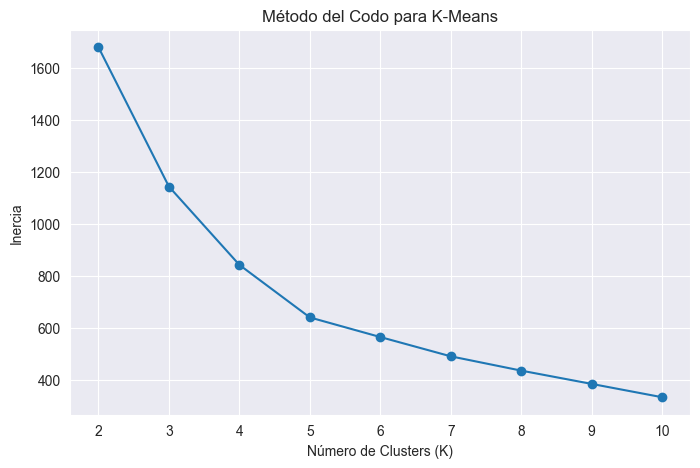

Observa el gráfico: elige el valor de K donde la línea 'forma un codo' (la disminución de la inercia se vuelve mucho más lenta).

>>> Aplicando K-Means con K=3 (¡Asegúrate de ajustar 'chosen_k' según el gráfico!) <<<

Etiquetas de cluster (0 a 2) añadidas al DataFrame (columna 'Cluster').

--- Análisis Descriptivo de los Clusters ---

Distribución de CVs por cluster:
Cluster
0    103
1    111
2    400
Name: count, dtype: int64

Medias de features por cluster:
Cluster                             0            1          2
texto_extraido_len        5271.514563  3335.873874  5228.5500
secciones_completas          8.582524     6.873874     8.4725
Website/Otro                 1.000000     0.117117     0.0000
Seccion_training_courses     1.000000     0.018018     1.0000

(Interpreta esto buscando diferencias grandes en las medias entre clusters)

--- Relación Exploratoria entre Clusters y 'Passed' ---

Tabla de Contingencia (Cluster vs Passed):
Passed     0    1
Cluster          
0         47

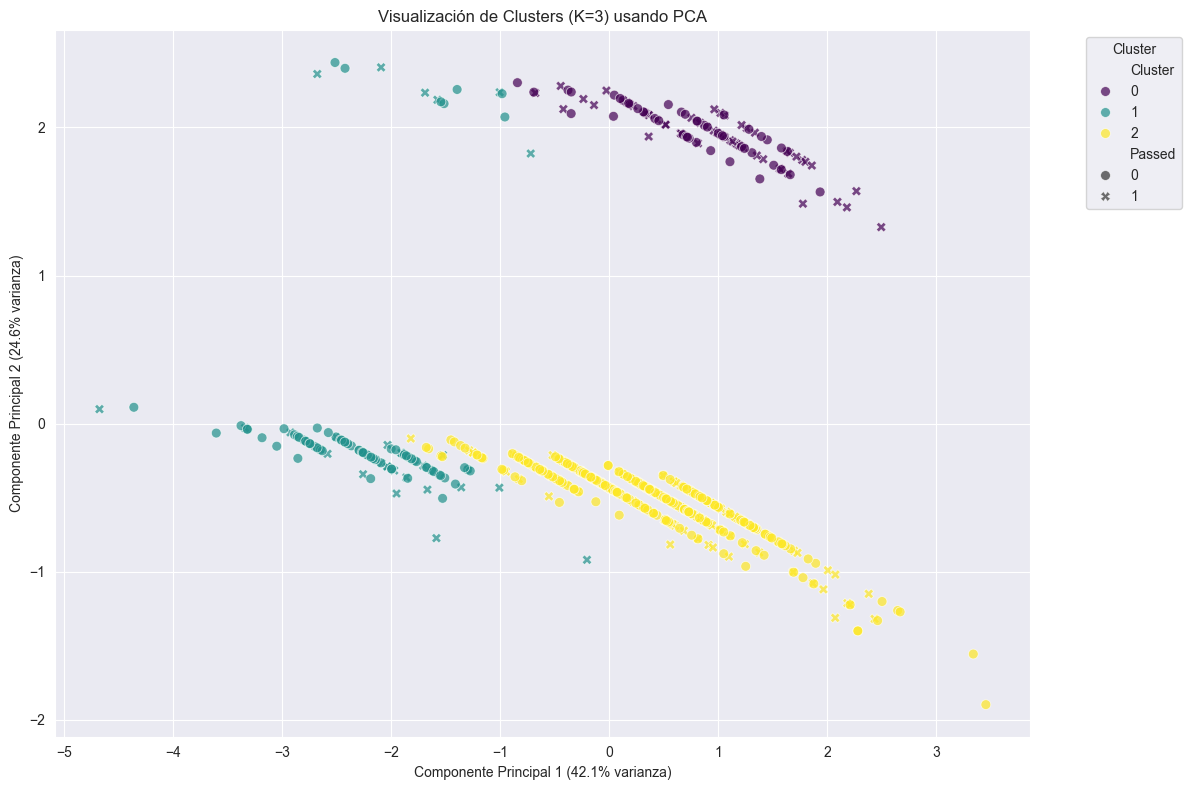

In [54]:
try:
    # Intentar detectar separador o especificarlo (ej. sep=',')
    df_cluster_orig = df4
    print(f"Datos cargados desde '{csv_path_cluster}'. Dimensiones: {df_cluster_orig.shape}")
    print("Columnas disponibles:", df_cluster_orig.columns.tolist())
except FileNotFoundError:
    print(f"Error: No se encontró el archivo '{csv_path_cluster}'.")
    df_cluster_orig = None
except Exception as e:
    print(f"Error cargando datos: {e}")
    df_cluster_orig = None

# --- Solo proceder si los datos se cargaron ---
if df_cluster_orig is not None:

    # --- 2. Preparar Datos para Clustering ---
    target_column = 'Passed'

    # Verificar si 'Passed' existe y separarla (la usaremos después)
    if target_column in df_cluster_orig.columns:
        y_labels = df_cluster_orig[target_column].copy()
        X_cluster = df_cluster_orig.drop(columns=[target_column])
        print(f"\nSeparando features (X) y target '{target_column}'.")
    else:
        print(f"\nAdvertencia: Columna '{target_column}' no encontrada. Se usarán todas las columnas para clustering.")
        y_labels = None
        X_cluster = df_cluster_orig.copy()

    # Asegurar que todas las features son numéricas
    original_cols = X_cluster.shape[1]
    X_cluster = X_cluster.select_dtypes(include=np.number)
    if X_cluster.shape[1] < original_cols:
         print(f"Advertencia: Se eliminaron {original_cols - X_cluster.shape[1]} columnas no numéricas.")

    # Verificar y manejar NaNs (Imputar si es necesario)
    if X_cluster.isnull().sum().sum() > 0:
        print(f"\nAdvertencia: {X_cluster.isnull().sum().sum()} NaNs encontrados. Imputando con la media...")
        from sklearn.impute import SimpleImputer
        imputer_cluster = SimpleImputer(strategy='mean')
        X_cluster_imputed = imputer_cluster.fit_transform(X_cluster)
        X_cluster = pd.DataFrame(X_cluster_imputed, columns=X_cluster.columns)
        print("Imputación completada.")
    else:
        print("\nNo se encontraron NaNs en las features.")

    # Guardar nombres de features
    feature_names_cluster = X_cluster.columns.tolist()
    print(f"Número de features para clustering: {len(feature_names_cluster)}")

    # --- 3. Escalar TODAS las Features ---
    print("\nEscalando todas las features para K-Means...")
    scaler_cluster = StandardScaler()
    X_scaled_cluster = scaler_cluster.fit_transform(X_cluster)
    print("Escalado completado.")

    # --- 4. Determinar Número Óptimo de Clusters (K) - Método del Codo ---
    print("\nCalculando inercia para K de 2 a 10 (Método del Codo)...")
    inertia = []
    k_range = range(2, 11) # Puedes ajustar este rango si quieres probar más clusters

    for k in k_range:
        kmeans_test = KMeans(n_clusters=k, random_state=42, n_init=10) # n_init='auto' en sklearn >= 1.3
        kmeans_test.fit(X_scaled_cluster)
        inertia.append(kmeans_test.inertia_) # Inertia: Suma de cuadrados intra-cluster

    # Graficar el codo
    try:
        plt.figure(figsize=(8, 5))
        plt.plot(k_range, inertia, marker='o')
        plt.xlabel('Número de Clusters (K)')
        plt.ylabel('Inercia')
        plt.title('Método del Codo para K-Means')
        plt.xticks(k_range)
        plt.grid(True)
        plt.show()
        print("Observa el gráfico: elige el valor de K donde la línea 'forma un codo' (la disminución de la inercia se vuelve mucho más lenta).")
    except Exception as e_elbow_plot:
         print(f"No se pudo generar el gráfico del codo: {e_elbow_plot}")

    # --- 5. Aplicar K-Means con K elegido ---
    # *** AJUSTA EL VALOR DE 'chosen_k' BASADO EN EL GRÁFICO DEL CODO ***
    chosen_k = 3  # Ejemplo: Elegir 4 clusters. ¡CAMBIA ESTO!
    print(f"\n>>> Aplicando K-Means con K={chosen_k} (¡Asegúrate de ajustar 'chosen_k' según el gráfico!) <<<")

    kmeans_final = KMeans(n_clusters=chosen_k, random_state=42, n_init=10)
    cluster_labels = kmeans_final.fit_predict(X_scaled_cluster)

    # Añadir etiquetas de cluster al DataFrame ORIGINAL (el que tiene 'Passed' si existía)
    df_clustered = df_cluster_orig.copy() # Usar el original cargado
    df_clustered['Cluster'] = cluster_labels
    print(f"\nEtiquetas de cluster (0 a {chosen_k-1}) añadidas al DataFrame (columna 'Cluster').")

    # --- 6. Análisis Básico de los Clusters ---
    print("\n--- Análisis Descriptivo de los Clusters ---")

    # Tamaño de cada cluster
    print("\nDistribución de CVs por cluster:")
    print(df_clustered['Cluster'].value_counts().sort_index())

    # Características promedio por cluster (usando las features seleccionadas antes del escalado)
    print("\nMedias de features por cluster:")
    # Usar 'feature_names_cluster' para asegurar que agrupamos por las columnas correctas
    try:
        cluster_analysis = df_clustered.groupby('Cluster')[feature_names_cluster].mean().transpose()
        pd.set_option('display.max_rows', None) # Mostrar todas las features
        print(cluster_analysis)
        pd.reset_option('display.max_rows')
        print("\n(Interpreta esto buscando diferencias grandes en las medias entre clusters)")
    except Exception as e_group:
        print(f"Error al calcular medias por cluster: {e_group}")


    # Relación con 'Passed' (si la columna existe)
    if y_labels is not None:
        print("\n--- Relación Exploratoria entre Clusters y 'Passed' ---")
        # Tabla de contingencia
        contingency_table = pd.crosstab(df_clustered['Cluster'], y_labels)
        print("\nTabla de Contingencia (Cluster vs Passed):")
        print(contingency_table)

        # Porcentaje de 'Passed' en cada cluster
        passed_perc_by_cluster = df_clustered.groupby('Cluster')['Passed'].mean() * 100
        print("\nPorcentaje de 'Passed'=1 en cada cluster (%):")
        print(passed_perc_by_cluster.round(2))

        # Prueba Chi-cuadrado
        try:
            chi2, p, dof, expected = chi2_contingency(contingency_table)
            print(f"\nPrueba Chi-cuadrado (Cluster vs Passed): p-value = {p:.4f}")
            if p < 0.05:
                print("--> Asociación significativa encontrada: La proporción de 'Passed' varía entre clusters.")
            else:
                print("--> No hay asociación significativa: La proporción de 'Passed' es similar entre clusters.")
        except ValueError:
            print("\nAdvertencia: No se pudo realizar Chi-cuadrado (posiblemente datos insuficientes).")
    else:
         print("\nColumna 'Passed' no disponible para análisis cruzado con clusters.")


    # --- 7. (Opcional) Visualización PCA ---
    print("\nGenerando visualización 2D de clusters usando PCA...")
    try:
        pca = PCA(n_components=2, random_state=42)
        # Usamos los datos escalados para PCA también
        X_pca = pca.fit_transform(X_scaled_cluster)
        print(f"Varianza explicada por los 2 componentes PCA: {pca.explained_variance_ratio_.sum():.2%}")

        # Crear DataFrame para graficar
        df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
        df_pca['Cluster'] = cluster_labels
        if y_labels is not None: # Añadir 'Passed' si existe para colorear diferente
             df_pca['Passed'] = y_labels

        plt.figure(figsize=(12, 8))
        sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Cluster',
                        palette='viridis', s=50, alpha=0.7,
                        style='Passed' if y_labels is not None else None) # Diferente marcador si 'Passed' existe
        plt.title(f'Visualización de Clusters (K={chosen_k}) usando PCA')
        plt.xlabel(f'Componente Principal 1 ({pca.explained_variance_ratio_[0]:.1%} varianza)')
        plt.ylabel(f'Componente Principal 2 ({pca.explained_variance_ratio_[1]:.1%} varianza)')
        plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    except Exception as e_pca_plot:
        print(f"No se pudo generar gráfico PCA: {e_pca_plot}")

#### Entendiendo los componentes principales
- Componente principal 1: Secciones completas y sección training courses. Medianamente explicado por la longitud del texto
- Componente principal 2: Tiene o no Website/Otro

Finalmente, entendemos que las 4 variables seleccionadas, así mismo explican la pertenencia a cierto tipo de cluster y la posibilidad de pertenecer a un grupo que pasa (o no) el filtro de nuestros clientes.
### Distribución de Clusters:
- Cluster 0: 103 CVs
- Cluster 1: 111 CVs
- Cluster 2: 400 CVs
Observaciones: Tenemos 2 clusters de tamaño similar (0 y 1) y un cluster muy grande (2) que agrupa a casi dos tercios de los CVs.
### Características Promedio por Cluster: La separación aquí es bastante clara, dominada por las dos variables binarias:
- Cluster 0: Siempre tienen Website/Otro (1.0) y siempre tienen Seccion_training_courses (1.0). Longitud y secciones promedio.
Perfil: "Con Website y Sección Training".
- Cluster 1: Casi nunca tienen Website/Otro (12%) y casi nunca tienen Seccion_training_courses (2%). Son los más cortos y con menos secciones en promedio.
Perfil: "Sin Training (y Mayormente sin Website)".
- Cluster 2: Nunca tienen Website/Otro (0.0) pero siempre tienen Seccion_training_courses (1.0). Longitud y secciones promedio (similar al Cluster 0). Es el grupo más numeroso.
Perfil: "Con Sección Training, Sin Website (Grupo Estándar)".
### Relación con 'Passed':
- Cluster 0 (Con Website y Training): 54.4% Passed (La más alta).
- Cluster 1 (Sin Training/Website): 32.4% Passed (La más baja).
- Cluster 2 (Con Training, Sin Website): 42.5% Passed (Cercana al promedio general).
- Prueba Chi-cuadrado (p=0.0052): ¡Muy significativo (p < 0.01)! Confirma que la proporción de CVs que 'Pasaron' es estadísticamente diferente entre estos 3 clusters.
- Interpretación: Este es un hallazgo clave. Los perfiles definidos por estas 4 variables sí están asociados con diferentes tasas de éxito promedio. Tener ambas características (Website/Otro y Seccion_training_courses) se asocia con la mayor tasa de éxito, mientras que carecer de la sección de training (y a menudo también del website) se asocia con la menor. El grupo grande intermedio (solo con Training) tiene una tasa de éxito cercana al promedio.

*Escribir conclusiones*

### Evaluación

In [55]:
# --- Añadir Evaluación Interna: Coeficiente de Silueta ---
from sklearn.metrics import silhouette_score

# Asegúrate que X_scaled_cluster y cluster_labels son los de la última ejecución
# (escalado de las 4 features, y las etiquetas del K-Means con K=5)
if 'X_scaled_cluster' in locals() and 'cluster_labels' in locals() and len(np.unique(cluster_labels)) > 1:
    try:
        silhouette_avg = silhouette_score(X_scaled_cluster, cluster_labels)
        print(f"\n--- Evaluación Interna del Clustering (K={chosen_k}) ---") # Asegúrate que chosen_k sea 5 aquí
        print(f"Coeficiente de Silueta Promedio: {silhouette_avg:.4f}")
        print("(Valores > 0.5 suelen indicar buena estructura, cercanos a 0 indican solapamiento)")
    except NameError:
        print("\nAsegúrate de que 'chosen_k' esté definido con el número de clusters usado (ej. 5).")
    except Exception as e_sil:
        print(f"Error calculando el Coeficiente de Silueta: {e_sil}")
else:
    print("\nNo se pueden calcular métricas de clustering (datos no disponibles o K<=1).")


--- Evaluación Interna del Clustering (K=3) ---
Coeficiente de Silueta Promedio: 0.4838
(Valores > 0.5 suelen indicar buena estructura, cercanos a 0 indican solapamiento)


### Explicación componentes principales

In [56]:
#target_column = 'Passed' # Necesitamos excluirla si está en el df
significant_features = [
    'texto_extraido_len',
    'secciones_completas',
    'Website/Otro',
    'Seccion_training_courses'
]

try:
    df_cluster_orig = df4
    # Seleccionar solo las 4 features usadas en el último clustering
    # y excluir el target si existe
    cols_to_use = [col for col in significant_features if col in df_cluster_orig.columns]
    if not cols_to_use:
         raise ValueError("Ninguna de las features especificadas se encontró.")
    X_cluster = df_cluster_orig[cols_to_use].copy()

    # Escalar los datos (fundamental para PCA)
    scaler_cluster = StandardScaler()
    X_scaled_cluster = scaler_cluster.fit_transform(X_cluster)
    feature_names = X_cluster.columns # Nombres de las 4 features

    print(f"Datos preparados para PCA con {X_cluster.shape[1]} features.")

    # --- Ajustar PCA ---
    # Ajustamos PCA con el número de componentes que quieres interpretar (ej. 2 o todos)
    n_components_pca = X_cluster.shape[1] # Ajustar con todas las componentes (4)
    pca = PCA(n_components=n_components_pca, random_state=42)
    pca.fit(X_scaled_cluster)

    # --- 1. Varianza Explicada ---
    print("\n--- Varianza Explicada por Componente Principal ---")
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance_ratio)
    for i, ratio in enumerate(explained_variance_ratio):
        print(f"  Componente Principal {i+1} (PC{i+1}): {ratio:.2%} (Acumulada: {cumulative_variance[i]:.2%})")

    # --- 2. Cargas de los Componentes ---
    print("\n--- Cargas (Contribución) de Features Originales en cada PC ---")
    # pca.components_ tiene forma (n_components, n_features)
    # Lo transponemos para verlo mejor: filas=features, columnas=PCs
    loadings_df = pd.DataFrame(pca.components_.T,
                               columns=[f'PC{i+1}' for i in range(n_components_pca)],
                               index=feature_names)

    # Mostramos todas las cargas
    print(loadings_df)

    # --- 3. Interpretación Guiada ---
    print("\n--- Interpretación (Variables con mayor peso absoluto en cada PC) ---")
    for i in range(n_components_pca):
        pc_name = f'PC{i+1}'
        print(f"\nInterpretando {pc_name} (Varianza: {explained_variance_ratio[i]:.2%}):")
        # Ordenar features por la magnitud (valor absoluto) de su carga en este PC
        sorted_loadings = loadings_df[pc_name].abs().sort_values(ascending=False)
        print(f"  Features ordenadas por influencia (mayor a menor magnitud) en {pc_name}:")
        # Mostrar las cargas ordenadas (con signo) para ver la dirección
        print(loadings_df.loc[sorted_loadings.index, pc_name])

        # Identificar las que tienen mayor carga (> umbral arbitrario, ej. 0.4 o 0.5)
        umbral_carga = 0.5 # Puedes ajustar este umbral
        altas_cargas_pos = loadings_df[pc_name][loadings_df[pc_name] >= umbral_carga].index.tolist()
        altas_cargas_neg = loadings_df[pc_name][loadings_df[pc_name] <= -umbral_carga].index.tolist()

        interpretacion = f"  -> {pc_name} representa principalmente un contraste entre "
        if altas_cargas_pos:
            interpretacion += f"[{', '.join(altas_cargas_pos)}] (altos valores de estas features aumentan el PC)"
        if altas_cargas_pos and altas_cargas_neg:
            interpretacion += " y "
        if altas_cargas_neg:
             interpretacion += f"[{', '.join(altas_cargas_neg)}] (altos valores de estas features disminuyen el PC)"
        if not altas_cargas_pos and not altas_cargas_neg:
             interpretacion = f"  -> {pc_name} no tiene features dominantes claras (cargas más distribuidas)."

        print(interpretacion)


except FileNotFoundError:
    print(f"Error: No se encontró el archivo '{csv_path_cluster}'.")
except KeyError as e:
    print(f"Error: Columna '{e}' no encontrada en el DataFrame. Revisa la lista 'significant_features'.")
except Exception as e:
    print(f"Ocurrió un error inesperado: {e}")

Datos preparados para PCA con 4 features.

--- Varianza Explicada por Componente Principal ---
  Componente Principal 1 (PC1): 42.15% (Acumulada: 42.15%)
  Componente Principal 2 (PC2): 24.62% (Acumulada: 66.77%)
  Componente Principal 3 (PC3): 19.46% (Acumulada: 86.23%)
  Componente Principal 4 (PC4): 13.77% (Acumulada: 100.00%)

--- Cargas (Contribución) de Features Originales en cada PC ---
                               PC1       PC2       PC3       PC4
texto_extraido_len        0.490068 -0.207738  0.833145 -0.150159
secciones_completas       0.617890 -0.067324 -0.246204  0.743682
Website/Otro              0.166346  0.975346  0.145004 -0.001909
Seccion_training_courses  0.591924 -0.031829 -0.473527 -0.651449

--- Interpretación (Variables con mayor peso absoluto en cada PC) ---

Interpretando PC1 (Varianza: 42.15%):
  Features ordenadas por influencia (mayor a menor magnitud) en PC1:
secciones_completas         0.617890
Seccion_training_courses    0.591924
texto_extraido_len       